# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [ ]:
import numpy as np
import seaborn as sns
import random
import string
import statistics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model, regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [ ]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/'] # a list of 4 binary operators we support
IDENTIFIERS = list('abcde') # the 5 variable names used as so-callled leaf nodes in generated expression trees
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS'] # PAD - used to pad every sequence to a fixed length (seemingly, for batching), SOS - start of sequence, EOS - end of sequence
SYMBOLS = ['(', ')', '+', '-', '*', '/'] # parentheses themselves in the vocabulary, since infix expressions are fully parenthesized
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation (We add an extra 'JUNK' just in case the model ever emits something it shouldn’t)

token_to_id = {tok: i for i, tok in enumerate(VOCAB)} # map each string token → integer index
id_to_token = {i: tok for tok, i in token_to_id.items()} # invert that, for decoding model outputs back to strings
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3 # MAX_DEPTH is the maximum recursion depth of our randomly generated expression trees
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [ ]:
# -------------------- Expression Generation --------------------

# to produce a random fully-parenthesized infix string of maximum nesting depth max_depth
def generate_infix_expression(max_depth):
    if max_depth == 0: # (Base case) Once max_depth hits zero we stop recursing and return a single identifier
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5: # some branches will be shallower than the maximum depth (this contrivance vouches for a nice melting pot of small and large subtrees)
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})' # wrap the two sub-strings and the operator

def tokenize(expr):
    return [c for c in expr if c in token_to_id] # filters symbols our model actually knows

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], [] # output: the list we’ll build up with identifiers and operators in postfix order, stack let's say is a temporary stack for operators and parentheses ensuring correct ordering
    for token in tokens:
        if token in IDENTIFIERS: # put the identifier forthwith into the output
            output.append(token)
        elif token in OPERATORS: # if it's an operator (+-*/)
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(': # left parenthesis (
            stack.append(token)
        elif token == ')': # right parenthesis )
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack: # drain the stack for any operators left belong at the end of the expression
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN): # Converts each symbol in our token list into its integer index via the token_to_id dictionary, appends the special “End-Of-Sequence” token ID,
                                     # eomputes how many padding slots we need so every sequence becomes exactly max_len long, extends our sequence with that many PAD tokens
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token=id_to_token, pad_token='PAD', eos_token='EOS'):

    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y) # X is a batch of infix-encoded inputs, Y is the corresponding true postfix-encoded targets
def data_generator(batch_size=128):
    while True:
        X, Y = generate_dataset(batch_size)
        yield {"infix_in":X, "post_in":shift_right(Y)}, Y
#we use the shift function for teacher-forcing
def shift_right(seqs): # seq is the target Y
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID # here we prepend the “Start-Of-Sequence” marker at time-step 0 for every sample
    return shifted

In [ ]:
def generate_infix_expression(d):
    if d==0 or random.random()<0.5:
        return random.choice(IDENTIFIERS)
    L = generate_infix_expression(d-1)
    R = generate_infix_expression(d-1)
    return f'({L}{random.choice(OPERATORS)}{R})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    prec, out, st = {'+':1,'-':1,'*':2,'/':2}, [], []
    for t in tokens:
        if t in IDENTIFIERS:
            out.append(t)
        elif t in OPERATORS:
            while st and st[-1] in OPERATORS and prec[st[-1]]>=prec[t]:
                out.append(st.pop())
            st.append(t)
        elif t=='(':
            st.append(t)
        else:
            while st[-1]!='(':
                out.append(st.pop())
            st.pop()
    while st:
        out.append(st.pop())
    return out

def encode(tokens):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID]*(MAX_LEN - len(ids))

def decode(ids):
    toks = []
    for i in ids:
        t = id_to_token[i]
        if t=='EOS': break
        if t!='PAD': toks.append(t)
    return ' '.join(toks)

def generate_dataset(n):
    X, Y = [], []
    for _ in range(n):
        infix = tokenize(generate_infix_expression(MAX_DEPTH))
        post  = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(post))
    return np.array(X, dtype=np.int32), np.array(Y, dtype=np.int32)

def shift_right(y):
    out = np.zeros_like(y)
    out[:,1:] = y[:,:-1]
    out[:,0]  = SOS_ID
    return out

Let us define a simple dataset, and inspect a few samples.

In [ ]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [ ]:
i =  np.random.randint(10000)
print(i)

print("infix :", decode_sequence(X_train[i]))
print("postfix notation:", decode_sequence(Y_train[i]))
print("teacher forcing :", decode_sequence(decoder_input_train[i]))


3663
infix : ( ( b / a ) / ( ( b * b ) / ( b - e ) ) )
postfix notation: b a / b b * b e - / /
teacher forcing : SOS b a / b b * b e - / /


# Transformer Module

First and foremost, we need to turn integer token IDs into continuous vectors that also carry information about each token's position in the sequence

Here we carry out class PositionEmbedding destined to combine embedding with positional settings.
**token_emb**: modifies each input token into numerical continuous vectors.
**position_emb**: this sort of embedding learns positional vectors, which encode information about the location of each token within the sequence. T put it in layman's terms, here we simply learn postional representations directly from data.

**!!!**: Vitally important it is to factor in position_emb as further applied transformer appears to be susceptible to order - no intrinsic sense of order, so to speak.

In [ ]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, max_len, dimensionality):
      super().__init__()
      # converts each discrete token ID into a learnt continuous vector of size dimensionality
      self.token_emb = layers.Embedding(VOCAB_SIZE, dimensionality)
      # same yet for positions instead of words
      self.position_emb = layers.Embedding(max_len, dimensionality)
  def call(self, x):
    # further on we rely upon dynamic shapes ([0] would be the batch size and [1] is the sequence length)
    length = tf.shape(x)[1]
    # “input IDs” for the positional embedding lookup
    positions = tf.range(length)
    return self.token_emb(x) + self.position_emb(positions)

# TRANSFORMER MODEL

We define our transformer within a function aptly named **build\_model**. From the outset, we embed input sequences using custom positional embeddings to effectively encode positional context alongside token information. Thoughtfully, we've integrated dropout and L2 regularisation across both embedding layers and intermediate layers aiming to boost generalisation and reduce the likelihood of overfitting.

***Input parameters:***

`maxlen` signifies the maximum sequence length the model handles ( it is needed for positional embeddings)

`d_model` is the embedding dimension size

`num_heads` is the number of attention heads (enables parallel attention to different feature spaces)

`d_ff` alludes to the dimension of the Feed-Forward Network (FFN)

`num_layers_enc`, `num_layers_dec` set the depth of encoder and decoder stacks.

`dropout_rate` serves as regularisation (randomly drops neuron activations to forestall overfitting)

`l2_reg` function as an L2 regularisation penalty to the kernel weights to encourage smaller weights to level uop generalisation.

In [ ]:
def build_model(
    maxlen=MAX_LEN, d_model=128,
    num_heads=6, d_ff=512,
    num_layers_enc=3, num_layers_dec=3,
    dropout_rate=0.15, l2_reg=1e-6
):
    infix_in = layers.Input((maxlen,), name="infix_in")
    post_in = layers.Input((maxlen,), name="post_in")

    # Embedding + Dropout part
    # *** Here immediately to prevent the model from becoming overly reliant on specific token representations
    enc_x = layers.Dropout(dropout_rate)(PositionalEmbedding(maxlen,d_model)(infix_in))
    dec_x = layers.Dropout(dropout_rate)(PositionalEmbedding(maxlen,d_model)(post_in))

    # ENCODER PART
    # *** Here we push forward repeated identical layers
    for i in range(num_layers_enc):

        # Attentions here is set to capture so-called contextual relationships
        attn = layers.MultiHeadAttention(num_heads,key_dim=d_model//num_heads,dropout=dropout_rate,kernel_regularizer=regularizers.l2(l2_reg))(enc_x, enc_x)
        attn = layers.Dropout(dropout_rate)(attn)

        # Normalisation serves for residual connection (enc_x + attn) maintenance of gradient flow. To put it differently, Normalisation helps in stabilising the distribution on the output
        x1 = layers.LayerNormalization(epsilon=1e-6)(enc_x + attn)

        # Two-layer dense structure (Expands (d_ff) whereupon these layers compresses (d_model) the representation).
        # Relu introduces non-linearity necessary for capturing more complex patterns
        ffn = layers.Dense(d_ff, activation='relu',kernel_regularizer=regularizers.l2(l2_reg))(x1)
        ffn = layers.Dropout(dropout_rate)(ffn)
        ffn = layers.Dense(d_model,kernel_regularizer=regularizers.l2(l2_reg))(ffn)
        enc_x = layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

    # DECODER PART
    for j in range(num_layers_dec):
        # A custom Lambda layer constructs a causal mask to ensure each position in the sequence can only attend to previous positions
        # preventing leakage of future information during training

        # CAUSAL MASKING IS ESSENTIAL FOR AUTOREGRESSIVE MOOD OF GENERATION!!
        def causal_mask(x):
            b = tf.shape(x)[0]; s = tf.shape(x)[1] # dynamically adapts to input sequences of varying batch sizes and lengths
            m = tf.linalg.band_part(tf.ones((s,s)),-1,0)
            return tf.tile(m[None], [b,1,1])
        mask = layers.Lambda(causal_mask)(dec_x)

        # Decoder's self-attention
        # *** Ensures each token prediction only uses previously known tokens
        att1 = layers.MultiHeadAttention(num_heads,key_dim=d_model//num_heads,dropout=dropout_rate,kernel_regularizer=regularizers.l2(l2_reg))(dec_x, dec_x, attention_mask=mask)
        att1 = layers.Dropout(dropout_rate)(att1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(dec_x + att1)

        # Cross-attention (Decoder-to-Encoder)
        # *** Allows the decoder to access and attend to the encoder’s output
        att2 = layers.MultiHeadAttention(num_heads,key_dim=d_model//num_heads,dropout=dropout_rate,kernel_regularizer=regularizers.l2(l2_reg))(x1, enc_x)
        att2 = layers.Dropout(dropout_rate)(att2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + att2)

        # -||- (for x2)
        ffn = layers.Dense(d_ff, activation='relu',kernel_regularizer=regularizers.l2(l2_reg))(x2)
        ffn = layers.Dropout(dropout_rate)(ffn)
        ffn = layers.Dense(d_model,kernel_regularizer=regularizers.l2(l2_reg))(ffn)
        dec_x = layers.LayerNormalization(epsilon=1e-6)(x2 + ffn)

    logits = layers.Dense(len(VOCAB), name="final_proj")(dec_x) # These logits reflect how strongly the model believes each vocabulary token is likely at each position in the output sequence
    return Model([infix_in, post_in], logits)

Autoregressive data generation
A model is autoregressive when it generates a sequence one token at a time, each time conditioning on all the tokens it has already produced

In [ ]:
# Greedy Decoding
# we input one fully tokenised infix expression (of shape MAX_LEN)
# output is a postfix expression predicted by the model (so let's say if i had [3,2,10,4,...] it turns to ["a b +"...])
def greedy_decode(model, x_seq, max_len=MAX_LEN):

    x_seq = x_seq[None]                  # (1, seq) is a batch dimension
    out   = []                           # previous prediction storage (generated token-ids)

    for step in range(max_len - 1):      # we also need '-1' here to allocate some room for the end of the string indicator
        dec_in = np.array([SOS_ID] + out + [PAD_ID]*(max_len-1-len(out)))[None] # also granted we need to align the lenght i add PAD (used to pad every sequence to a fixed length)
        # FORWARD PASS
        # the encoder sees the whole infix expression at once
        # the decoder sees only the prefix via causal mask (causal mask is needed here since self-attention lets every position look at all other positions in the same sequence. Hence it can peek at what the model is predicting which is fundamentally wrong)
        logits = model.predict(
            {"infix_in": x_seq, "post_in": dec_in},
            verbose=0
        )
        next_id = int(np.argmax(logits[0, len(out)]))   # GREEDY SEARCH

        if next_id == EOS_ID: # END!
            break
        out.append(next_id)

    return out

# Metric

loss_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # goes about token-by-token instead of merely tracking the ordinary cross-entropy loss

def loss_with_mask(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, PAD_ID), tf.float32) # we compare every element of the ground-truth tensor with the constant PAD_ID. Eventually we deduce a tensor which contains "True" at positions that should be kept and False where the token is PAD
    loss = loss_ce(y_true, y_pred) * mask # merging with the mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask) # calculating mean over real tokens

def prefix_acc_single(y_true_batch, y_pred_batch): # per a batch
    accs = []
    for y_t, y_p in zip(y_true_batch, y_pred_batch):
        t = decode(y_t).split() # ground truth tokens
        p = decode(y_p).split() # predicted tokens
        m = max(len(t), len(p))
        accs.append(sum(a == b for a, b in zip(t, p)) / m if m else 0)
    return np.mean(accs).astype("float32")


def prefix_acc(y_true, y_pred):
    y_pred_ids = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    acc = tf.numpy_function(prefix_acc_single, [y_true, y_pred_ids],
                            tf.float32)
    acc.set_shape(())
    return acc




# Test
def test(model, no=20, rounds=10):
    scores = []
    for _ in range(rounds):
        Xv, Yv = generate_dataset(no)
        sc = [prefix_acc_single(y, greedy_decode(model,x))
              for x,y in zip(Xv,Yv)]
        scores.append(statistics.mean(sc))
    return statistics.mean(scores), statistics.stdev(scores)

# **Training and Results**

We train for up to 30 epochs turning to good account the following settings:

- **Batch size:** 128  
- **Steps per epoch:** 100  
- **Optimizer:** AdamW(1e-3, weight_decay=1e-6)  
- **Loss:** SparseCategoricalCrossentropy(from_logits=True)  
- **Metrics:** token-level sparse categorical accuracy  
- **Dropout:** 0.15 in attention & FFN sublayers (plus 0.15 after embeddings)  
- **L2 weight decay:** 1e-6 on all projection kernels  
- **EarlyStopping:** monitor val_accuracy, patience=3, restore best  
- **ReduceLROnPlateau:** halve LR when val_accuracy stalls, min_lr=1e-6  

Besides, in the course of the present we kick off training and capture the returned `history`

In principle, 30 epochs were come down in favour of largely as an upper bound rather than because we expect the model to need that many passes. Exactly for the reason of optimising time consumption, EarlyStoppint was deployed in the model. FOrthwith upon stagnation in validation accuracy (stops improving for 3 epochs on the trot), the model's training halts. hence 30 is just a high ceiling.

In [ ]:
if __name__ == "__main__":
    tf.keras.utils.set_random_seed(0)

    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=loss_with_mask,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="tok_acc"),
            prefix_acc
        ]
    )
    model.summary()
    # ─── validation set ───
    X_val, Y_val   = generate_dataset(2000)
    post_val_shift = shift_right(Y_val)

    # ─── training generator (Keras expects *a generator*, not a function) ───
    def train_gen(batch_size=128):
        while True:
            X, Y = generate_dataset(batch_size)
            yield {"infix_in": X,
                   "post_in":  shift_right(Y)}, Y

    callbacks = [
        EarlyStopping(monitor="val_tok_acc", patience=2, mode="max",
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_tok_acc", factor=0.5,
                          patience=1, mode="max", min_lr=1e-5)
    ]

    history = model.fit(
        train_gen(128),
        steps_per_epoch=100,
        epochs=10,
        validation_data=({"infix_in": X_val,
                          "post_in":  post_val_shift}, Y_val),
        callbacks=callbacks,
        verbose=2
    )

    # ─── quick sanity-check ───
    # X_test, Y_test = make_dataset(20)
    # preds  = [greedy_decode(model, x) for x in X_test]
    # scores = [prefix_acc_single(y, p) for y, p in zip(Y_test, preds)]
    # print(f"\nPrefix-accuracy on 20 fresh samples: "
    #       f"{np.mean(scores):.3f} ± {np.std(scores):.3f}")

    X_test, Y_test = generate_dataset(20)
    pairings = [decode(Y_test[i]) == decode(greedy_decode(model, X_test[i])) for i in range(20)]
    print(f"\nPrefix-accuracy on 20 fresh samples: ", f"{np.mean(pairings):.3f} ± {np.std(pairings):.3f}")

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ infix_in            │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 30, 128)   │      5,760 │ infix_in[0][0]    │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_260         │ (None, 30, 128)   │          0 │ positional_embed… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 128)   │     65,018 │ dropout_260[0][0… │
│ (MultiHeadAttentio… │                   │            │ dropout_260[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_263         │ (None, 30, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_150 (Add)       │ (None, 30, 128)   │          0 │ dropout_260[0][0… │
│                     │                   │            │ dropout_263[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ add_150[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 30, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_264         │ (None, 30, 512)   │          0 │ dense_120[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 30, 128)   │     65,664 │ dropout_264[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_151 (Add)       │ (None, 30, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_121[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ add_151[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 128)   │     65,018 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_266         │ (None, 30, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_152 (Add)       │ (None, 30, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_266[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ add_152[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 30, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_267         │ (None, 30, 512)   │          0 │ dense_122[0][0] 

 Total params: 1,392,729 (5.31 MB)

 Trainable params: 1,392,729 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 - 293s - 3s/step - loss: 1.3540 - prefix_acc: 0.5626 - tok_acc: 0.0805 - val_loss: 0.6542 - val_prefix_acc: 0.8540 - val_tok_acc: 0.1244 - learning_rate: 1.0000e-03
Epoch 2/10
100/100 - 258s - 3s/step - loss: 0.4461 - prefix_acc: 0.9076 - tok_acc: 0.1389 - val_loss: 0.1071 - val_prefix_acc: 0.9799 - val_tok_acc: 0.1616 - learning_rate: 1.0000e-03
Epoch 3/10
100/100 - 272s - 3s/step - loss: 0.0979 - prefix_acc: 0.9821 - tok_acc: 0.1601 - val_loss: 0.0228 - val_prefix_acc: 0.9973 - val_tok_acc: 0.1668 - learning_rate: 1.0000e-03
Epoch 4/10
100/100 - 257s - 3s/step - loss: 0.0418 - prefix_acc: 0.9929 - tok_acc: 0.1648 - val_loss: 0.0309 - val_prefix_acc: 0.9934 - val_tok_acc: 0.1664 - learning_rate: 1.0000e-03
Epoch 5/10
100/100 - 244s - 2s/step - loss: 0.0210 - prefix_acc: 0.9967 - tok_acc: 0.1668 - val_loss: 0.0090 - val_prefix_acc: 0.9986 - val_tok_acc: 0.1674 - learning_rate: 5.0000e-04
Epoch 6/10
100/100 - 254s - 3s/step - loss: 0.0144 - prefix_acc: 0.9979 - tok_ac

# **Training and validation loss curves**

# Loss

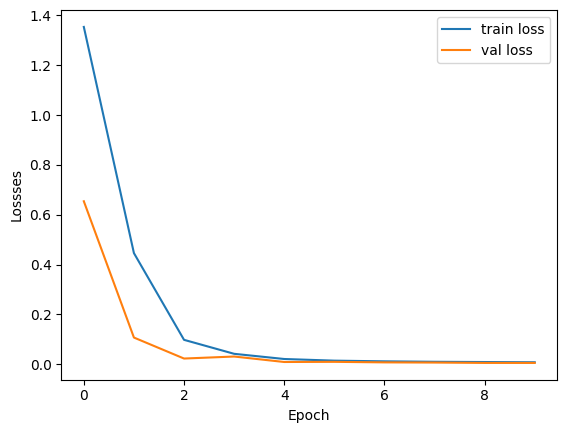

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Lossses')
plt.legend()
plt.show()

# Accuracy

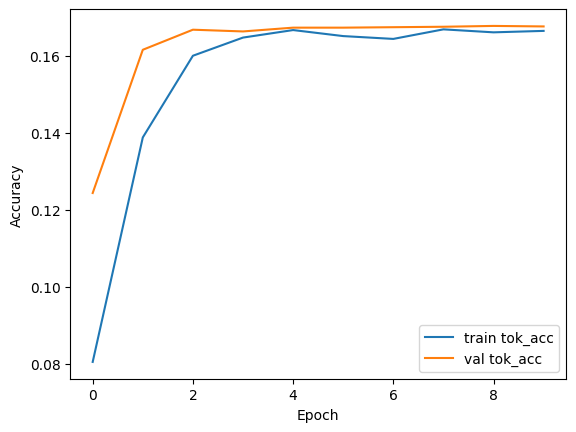

In [ ]:
plt.plot(history.history['tok_acc'],      label='train tok_acc')
plt.plot(history.history['val_tok_acc'],  label='val tok_acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.